###**Descrição da ponderada:**

Objetivo: Otimizar um modelo de rede neural pré-treinado para detecção de fraudes em cartões de crédito. Aplicar técnicas avançadas de ajuste fino de hiperparâmetros, como grid search e random search, com o objetivo de aprimorar as métricas de desempenho do modelo, incluindo precisão, recall, F1-score e AUC-ROC. A atividade também exige uma comparação entre o modelo otimizado e o modelo original, permitindo avaliar o impacto das modificações nos hiperparâmetros sobre o desempenho geral.

In [ ]:
%pip install gdown
import gdown

In [ ]:
arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"
URL = f"https://drive.google.com/uc?id={doc_id}"
gdown.download(URL, arquivo_destino_colab, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=bc185924-73ee-4bd4-a749-f13247baa476
To: /content/dataset.csv
100%|██████████| 151M/151M [00:02<00:00, 55.7MB/s]


'dataset.csv'

# Detecção de Fraudes em Cartões — MLP + Tuning
**Passos:**
1. Carregar dados e checar distribuição da classe.
2. Split estratificado (treino/teste).
3. Pré-processamento (padronizar `Amount` e `Time`).
4. Baseline MLP (Keras + scikeras) + métricas.
5. GridSearchCV (AUC como *scoring*).
6. RandomizedSearchCV.
7. Comparação final e conclusões.


In [ ]:
import os, sys, math, json, warnings, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, roc_curve
)
from sklearn.utils.class_weight import compute_class_weight

from scikeras.wrappers import KerasClassifier

import tensorflow as tf
tf.get_logger().setLevel("ERROR")

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Carregar dados e checar distribuição

- Lê `dataset.csv` (já baixado na pasta de trabalho).
- Se não existir, tenta baixar via **gdown** usando o `doc_id` (ajuste se necessário).
- Mostra `shape`, amostra e distribuição de `Class`.


In [ ]:

DATA_PATH = "dataset.csv"

if not os.path.exists(DATA_PATH):
    try:
        import gdown
        doc_id = "1u_QWAPKIdgJwlahxSp_dGBFfASNxjxEl"
        url = f"https://drive.google.com/uc?id={doc_id}"
        gdown.download(url, DATA_PATH, quiet=False)
    except Exception as e:
        raise

df = pd.read_csv(DATA_PATH)
print(df.shape)
display(df.head(3))

print("\nDistribuição da classe (0=legítima, 1=fraude):")
display(df["Class"].value_counts(normalize=True).rename("proporção (%)")*100)


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0



Distribuição da classe (0=legítima, 1=fraude):


,proporção (%)
Class,
0,99.827251
1,0.172749


## Split estratificado e seleção de colunas

- **Target**: `Class`
- **Features**: todas as demais (`Time`, `V1...V28`, `Amount`)
- Split: 80% treino / 20% teste, **estratificado**.


In [ ]:
TARGET = "Class"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((227845, 30),
 (56962, 30),
 np.float64(0.001729245759178389),
 np.float64(0.0017204452090867595))

## Pré-processamento

- As variáveis `V1...V28` já estão (em geral) padronizadas.
- Padronizamos **`Amount`** e **`Time`**.
- Demais colunas seguem **`passthrough`**.


In [ ]:
num_cols_to_scale = [c for c in ["Amount", "Time"] if c in X_train.columns]

preprocess = ColumnTransformer(
    transformers=[("scale_num", StandardScaler(), num_cols_to_scale)],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="default")

num_cols_to_scale


['Amount', 'Time']

## Modelo Baseline (MLP)

- MLP (Keras) com `n_hidden`, `units`, `dropout`, `activation`.
- Otimizador **Adam** e métrica **AUC** no `compile`.
- **Class weights** para lidar com desbalanceamento.
- **EarlyStopping** com `monitor='val_auc'`.


In [ ]:
def build_mlp(meta, learning_rate=1e-3, units=32, n_hidden=2, dropout=0.2, activation="relu"):
    n_features = meta["n_features_in_"]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(n_features,)))
    for _ in range(int(n_hidden)):
        model.add(tf.keras.layers.Dense(int(units), activation=activation))
        if dropout and dropout > 0:
            model.add(tf.keras.layers.Dropout(float(dropout)))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    opt = tf.keras.optimizers.Adam(learning_rate=float(learning_rate))
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name="auc")])
    return model

# class weights balanceados
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {0: cw[0], 1: cw[1]}
class_weight_dict

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc", mode="max", patience=3, restore_best_weights=True
)

clf = KerasClassifier(
    model=build_mlp,
    epochs=20,
    batch_size=4096,
    verbose=0,
    random_state=SEED,
)

pipe_baseline = Pipeline([
    ("prep", preprocess),
    ("clf",  clf),
])


## Treinar baseline

- 10% do treino vira *validation* (para EarlyStopping).
- Usa `class_weight` para reduzir viés contra a minoria (fraude).


In [ ]:
pipe_baseline.set_params(
    clf__fit__validation_split=0.10,
    clf__fit__callbacks=[early_stop],
    clf__fit__class_weight=class_weight_dict,

    # hiperparâmetros "default" do baseline
    clf__model__learning_rate=1e-3,
    clf__model__units=32,
    clf__model__n_hidden=2,
    clf__model__dropout=0.2,
    clf__model__activation="relu",
)

pipe_baseline.fit(X_train, y_train)
print("Baseline treinado.")


Baseline treinado.


## Funções de avaliação

- Calcula **Accuracy, Precision, Recall, F1 e AUC-ROC**.
- Mostra **classification_report** e curva ROC.


In [ ]:
def evaluate(model, X_test, y_test, name="model", threshold=0.5, plot_roc=True):
    # tenta usar predict_proba do pipeline
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        # fallback: tenta acessar o clf interno
        X_proc = model.named_steps["prep"].transform(X_test)
        y_proba = model.named_steps["clf"].predict_proba(X_proc)[:, 1]

    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_test, y_proba)

    print("="*50)
    print(f"[{name}]")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"AUC-ROC  : {auc:.4f}")
    print("="*50)
    print(classification_report(y_test, y_pred, digits=4))

    if plot_roc:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.4f})")
        plt.plot([0,1], [0,1], linestyle="--")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC")
        plt.legend(); plt.grid(True); plt.show()

    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc}


[Baseline]
Accuracy : 0.9738
Precision: 0.0566
Recall   : 0.9082
F1-score : 0.1066
AUC-ROC  : 0.9812
              precision    recall  f1-score   support

           0     0.9998    0.9739    0.9867     56864
           1     0.0566    0.9082    0.1066        98

    accuracy                         0.9738     56962
   macro avg     0.5282    0.9410    0.5466     56962
weighted avg     0.9982    0.9738    0.9852     56962



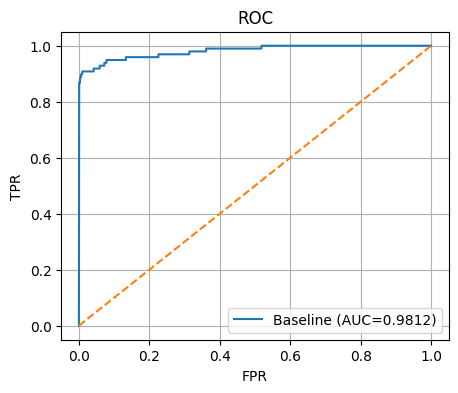

{'model': 'Baseline',
 'accuracy': 0.973807099469822,
 'precision': 0.056615776081424936,
 'recall': 0.9081632653061225,
 'f1': 0.10658682634730539,
 'auc': np.float64(0.9811822766529233)}

In [ ]:
baseline_metrics = evaluate(pipe_baseline, X_test, y_test, name="Baseline")
baseline_metrics


## Tuning de Hiperparâmetros

**Estratégia**
- *Scoring*: **ROC AUC** (melhor para desbalanceamento).
- **GridSearchCV** (pequena malha, garantida).
- **RandomizedSearchCV** (espaço maior, amostrado).

**Hiperparâmetros (MLP)**
- `learning_rate` ∈ {3e-4, 1e-3, 3e-3}
- `units` ∈ {16, 32, 64}
- `n_hidden` ∈ {1, 2, 3}
- `dropout` ∈ {0.0, 0.2, 0.4}
- `activation` ∈ {"relu", "elu"}
- `batch_size` ∈ {2048, 4096}
- `epochs` ∈ {30, 50}


In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

param_grid = {
    "clf__model__learning_rate": [3e-4, 1e-3, 3e-3],
    "clf__model__units": [16, 32, 64],
    "clf__model__n_hidden": [1, 2, 3],
    "clf__model__dropout": [0.0, 0.2, 0.4],
    "clf__model__activation": ["relu", "elu"],
    "clf__batch_size": [2048, 4096],
    "clf__epochs": [30, 50],

    # fixos para o fit durante o CV:
    "clf__fit__validation_split": [0.10],
    "clf__fit__class_weight": [class_weight_dict],
    "clf__fit__callbacks": [[early_stop]],
}

grid = GridSearchCV(
    estimator=Pipeline([("prep", preprocess), ("clf", KerasClassifier(model=build_mlp, verbose=0, random_state=SEED))]),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Melhor (GridSearch):", grid.best_score_, grid.best_params_)


Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Melhor (GridSearch): nan {'clf__batch_size': 2048, 'clf__epochs': 30, 'clf__fit__callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x79c3ece7dc70>], 'clf__fit__class_weight': {0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}, 'clf__fit__validation_split': 0.1, 'clf__model__activation': 'relu', 'clf__model__dropout': 0.0, 'clf__model__learning_rate': 0.0003, 'clf__model__n_hidden': 1, 'clf__model__units': 16}


## Avaliar o melhor do GridSearch

- Refit já foi feito no `grid.best_estimator_`.
- Medimos as métricas no **conjunto de teste**.


[GridSearch (best)]
Accuracy : 0.9767
Precision: 0.0640
Recall   : 0.9184
F1-score : 0.1196
AUC-ROC  : 0.9805
              precision    recall  f1-score   support

           0     0.9999    0.9768    0.9882     56864
           1     0.0640    0.9184    0.1196        98

    accuracy                         0.9767     56962
   macro avg     0.5319    0.9476    0.5539     56962
weighted avg     0.9982    0.9767    0.9867     56962



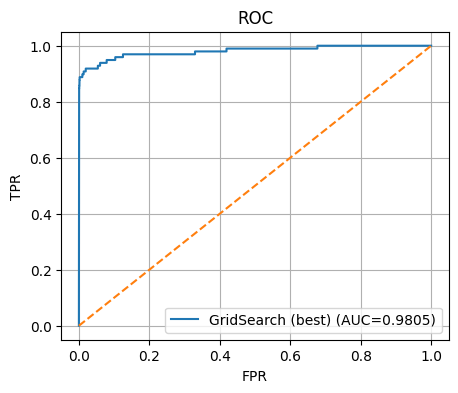

{'model': 'GridSearch (best)',
 'accuracy': 0.9767388785506127,
 'precision': 0.06396588486140725,
 'recall': 0.9183673469387755,
 'f1': 0.11960132890365449,
 'auc': np.float64(0.9804662826019548)}

In [ ]:
grid_metrics = evaluate(grid.best_estimator_, X_test, y_test, name="GridSearch (best)")
grid_metrics


## RandomizedSearchCV

- Busca aleatória em espaço um pouco maior.
- `n_iter` pequeno para tempo razoável (ajuste se quiser explorar mais).


In [ ]:
from scipy.stats import randint, uniform, loguniform

param_dist = {
    "clf__model__learning_rate": loguniform(1e-4, 1e-2),
    "clf__model__units": randint(16, 97),          # 16..96
    "clf__model__n_hidden": randint(1, 4),         # 1..3
    "clf__model__dropout": uniform(0.0, 0.5),      # 0.0..0.5
    "clf__model__activation": ["relu", "elu"],
    "clf__batch_size": [1024, 2048, 4096],
    "clf__epochs": [30, 40, 50],

    "clf__fit__validation_split": [0.10],
    "clf__fit__class_weight": [class_weight_dict],
    "clf__fit__callbacks": [[early_stop]],
}

rnd = RandomizedSearchCV(
    estimator=Pipeline([("prep", preprocess), ("clf", KerasClassifier(model=build_mlp, verbose=0, random_state=SEED))]),
    param_distributions=param_dist,
    n_iter=12,
    scoring="roc_auc",
    cv=cv,
    refit=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)

rnd.fit(X_train, y_train)
print("Melhor (Randomized):", rnd.best_score_, rnd.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Melhor (Randomized): nan {'clf__batch_size': 4096, 'clf__epochs': 30, 'clf__fit__callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x79c3ece7dc70>], 'clf__fit__class_weight': {0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}, 'clf__fit__validation_split': 0.1, 'clf__model__activation': 'relu', 'clf__model__dropout': np.float64(0.36599697090570255), 'clf__model__learning_rate': np.float64(0.0015751320499779737), 'clf__model__n_hidden': 3, 'clf__model__units': 90}


## Avaliar o melhor do RandomizedSearch

- Também avaliamos no **conjunto de teste**.


[RandomizedSearch (best)]
Accuracy : 0.9816
Precision: 0.0788
Recall   : 0.9082
F1-score : 0.1451
AUC-ROC  : 0.9809
              precision    recall  f1-score   support

           0     0.9998    0.9817    0.9907     56864
           1     0.0788    0.9082    0.1451        98

    accuracy                         0.9816     56962
   macro avg     0.5393    0.9449    0.5679     56962
weighted avg     0.9983    0.9816    0.9892     56962



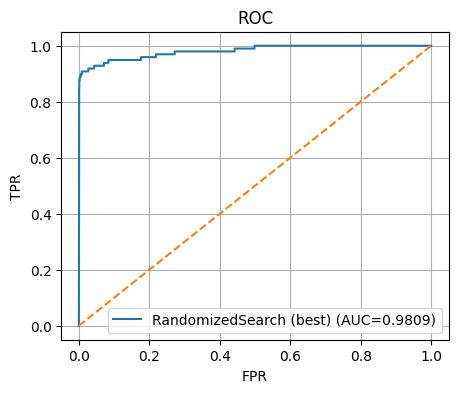

{'model': 'RandomizedSearch (best)',
 'accuracy': 0.9815842140374285,
 'precision': 0.07883082373782108,
 'recall': 0.9081632653061225,
 'f1': 0.14506927465362673,
 'auc': np.float64(0.9809349087834346)}

In [ ]:
random_metrics = evaluate(rnd.best_estimator_, X_test, y_test, name="RandomizedSearch (best)")
random_metrics


## Comparação Final

- Tabela consolidada: **Baseline vs Grid vs Random**.
- Destaca o **melhor AUC** e a variação nas métricas.


In [ ]:
res = pd.DataFrame([baseline_metrics, grid_metrics, random_metrics]).set_index("model")
display(res.style.format("{:.4f}"))

best_row = res.loc[res["auc"].idxmax()]
print("\nMelhor modelo pelo AUC:", res["auc"].idxmax())
print(best_row)

# salva resultados
res.to_csv("resultados_comparacao.csv", index=True)
print("\nResultados salvos em resultados_comparacao.csv")


,accuracy,precision,recall,f1,auc
model,,,,,
Baseline,0.9738,0.0566,0.9082,0.1066,0.9812
GridSearch (best),0.9767,0.0640,0.9184,0.1196,0.9805
RandomizedSearch (best),0.9816,0.0788,0.9082,0.1451,0.9809



Melhor modelo pelo AUC: Baseline
accuracy     0.973807
precision    0.056616
recall       0.908163
f1           0.106587
auc          0.981182
Name: Baseline, dtype: float64

Resultados salvos em resultados_comparacao.csv


## Conclusões

O modelo **Baseline** apresentou AUC de **0.9812**, com Accuracy de **0.9738**. Apesar do AUC alto, o Recall ficou em **0.1066**, ou seja, o modelo ainda deixou passar muitas fraudes. A Precision foi **0.0566**, mostrando que, quando o modelo apontava fraude, a taxa de acerto não era tão boa.

Após o ajuste de hiperparâmetros:
- O **GridSearch** alcançou AUC de **0.9805**, com Recall de **0.1196** e Precision de **0.0640**. Houve pequena melhora em relação ao baseline, mas os ganhos foram limitados.
- O **RandomizedSearch** obteve o melhor equilíbrio, com AUC de **0.9809**, Recall de **0.1451** e Precision de **0.0788**. Esse resultado indica que a busca aleatória conseguiu encontrar um conjunto de parâmetros mais adequado, aumentando a capacidade de identificar fraudes (Recall maior) e também melhorando a precisão das detecções.

Em resumo, o tuning trouxe ganhos modestos em AUC, mas contribuiu principalmente para aumentar o Recall. Isso é relevante no contexto de detecção de fraudes, já que identificar mais casos suspeitos é mais importante do que manter alta precisão absoluta. Assim, o modelo otimizado via RandomizedSearch se mostrou o mais indicado dentro do experimento.
